In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_14_45_32
NN-MODEL FILENAME:  ./models/VBKG0BIX_14_45_32_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1256.64 MiB, increment: 1036.31 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


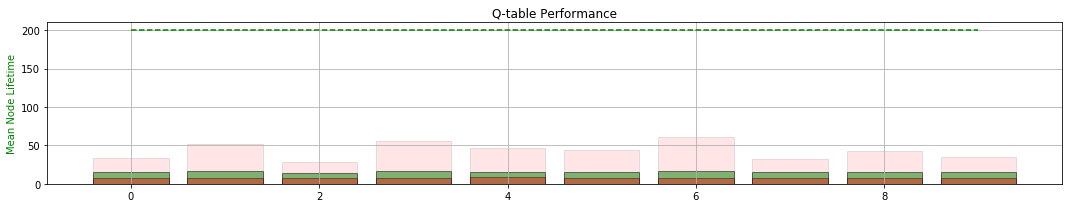

MEMORY COUNTER:  15558
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 554.511	LOSS : 494.187	LOSS : 501.537	LOSS : 462.312	LOSS : 482.520	LOSS : 453.713	LOSS : 461.374	LOSS : 438.435	LOSS : 427.280	LOSS : 426.650	LOSS : 437.595	LOSS : 416.630	LOSS : 417.081	LOSS : 409.456	LOSS : 399.023	LOSS : 386.797	LOSS : 390.277	LOSS : 394.987	LOSS : 370.245	LOSS : 380.651	
Validating... MEAN TIME:  131.065
LOSS : 374.989	LOSS : 378.491	LOSS : 374.128	LOSS : 374.044	LOSS : 373.400	LOSS : 381.074	LOSS : 372.655	LOSS : 385.132	LOSS : 376.238	LOSS : 378.128	LOSS : 380.476	LOSS : 376.502	LOSS : 380.154	LOSS : 392.345	LOSS : 381.279	LOSS : 387.024	LOSS : 396.467	LOSS : 392.471	LOSS : 408.981	LOSS : 388.296	
Validating... MEAN TIME:  141.365
LOSS : 396.223	LOSS : 393.076	LOSS : 399.610	LOSS : 414.616	LOSS : 415.246	LOSS : 419.982	LOSS : 402.952	LOSS : 411.284	LOSS : 414.229	LOSS : 419.704	LOSS : 434.743	LOSS : 443.188	LOSS : 424.811	LOSS : 442.441	LOSS : 444.998	LOSS : 457.682	LOSS : 4

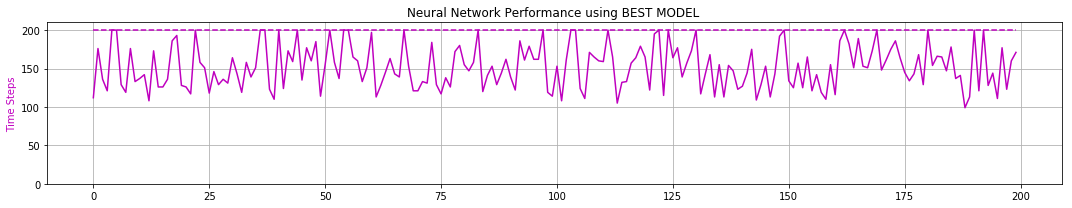

peak memory: 1313.70 MiB, increment: 1035.32 MiB
0 -max- 0.3382055600091699
0 -min- -0.15372057664315844

1 -max- 0.3641323472136863
1 -min- -0.1259997707058564

2 -max- 0.24880814656020075
2 -min- -0.17259134516963223

3 -max- 0.9095932699454365
3 -min- -0.18516543923232764

4 -max- 0.5902412856226918
4 -min- -0.10789477507402397

5 -max- 0.35459384224673773
5 -min- -0.16163006166024324

6 -max- 0.7557201376212002
6 -min- -0.12614762659059453

7 -max- 0.25819470292302377
7 -min- -0.05797750207110142

8 -max- 0.21581484058525288
8 -min- -0.2965588326782934

9 -max- 0.2718699399412684
9 -min- -0.16295813989512056

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   88005
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   103563
TOTAL PARALLEL TIMESTEPS: 261


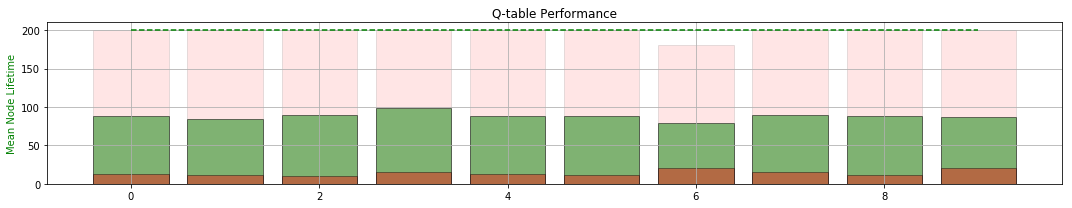

MEMORY COUNTER:  103563
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 596.666	LOSS : 536.903	LOSS : 501.911	LOSS : 452.082	LOSS : 454.591	LOSS : 422.691	LOSS : 404.813	LOSS : 377.910	LOSS : 357.944	LOSS : 352.388	LOSS : 328.338	LOSS : 319.502	LOSS : 318.761	LOSS : 313.561	LOSS : 292.932	LOSS : 296.134	LOSS : 288.271	LOSS : 286.930	LOSS : 285.988	LOSS : 290.837	
Validating... MEAN TIME:  134.425
LOSS : 303.374	LOSS : 286.544	LOSS : 257.106	LOSS : 269.356	LOSS : 275.481	LOSS : 253.702	LOSS : 256.325	LOSS : 249.742	LOSS : 256.567	LOSS : 260.177	LOSS : 250.136	LOSS : 262.894	LOSS : 264.498	LOSS : 264.710	LOSS : 263.936	LOSS : 267.640	LOSS : 263.469	LOSS : 248.839	LOSS : 268.334	LOSS : 275.166	
Validating... MEAN TIME:  144.19
LOSS : 259.397	LOSS : 260.582	LOSS : 253.420	LOSS : 251.041	LOSS : 262.359	LOSS : 271.368	LOSS : 265.770	LOSS : 273.063	LOSS : 276.150	LOSS : 272.654	LOSS : 264.562	LOSS : 265.136	LOSS : 264.982	LOSS : 259.932	LOSS : 272.755	LOSS : 267.125	LOSS : 2

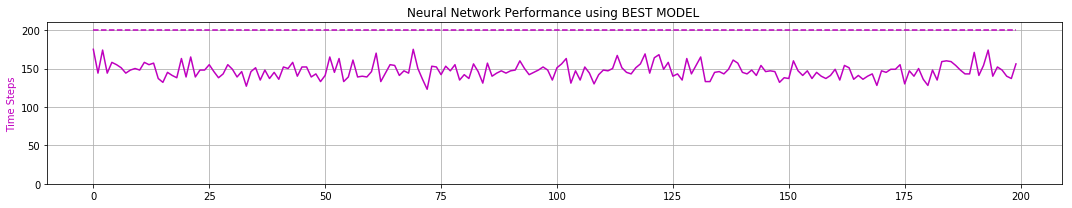

peak memory: 1395.75 MiB, increment: 1048.18 MiB
0 -max- 0.9154735088850591
0 -min- -0.9696072431487601

1 -max- 0.9916129014138593
1 -min- -1.201344949314161

2 -max- 0.8489132553037247
2 -min- -1.048671951340785

3 -max- 0.8555178017049795
3 -min- -0.9799546900789543

4 -max- 1.0353439796519661
4 -min- -0.9232708651695511

5 -max- 1.0068733026698633
5 -min- -1.1056670587802184

6 -max- 0.7770317414980339
6 -min- -1.1435891704926322

7 -max- 1.1381851030903893
7 -min- -1.1763807480350448

8 -max- 1.0087421466508568
8 -min- -0.9797318777248294

9 -max- 0.9819835315475249
9 -min- -0.956355678115319

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   82490
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 133
TOTAL SERIAL TIMESTEPS:   186053
TOTAL PARALLEL TIMESTEPS: 394


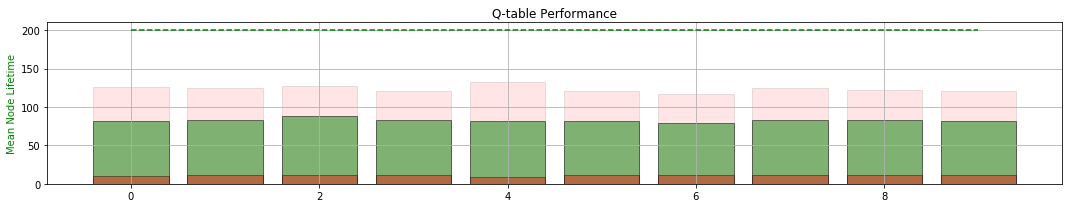

MEMORY COUNTER:  186053
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 318.651	LOSS : 303.702	LOSS : 288.609	LOSS : 306.626	LOSS : 297.010	LOSS : 297.178	LOSS : 290.515	LOSS : 285.968	LOSS : 298.166	LOSS : 330.050	LOSS : 299.919	LOSS : 308.435	LOSS : 267.125	LOSS : 281.120	LOSS : 283.806	LOSS : 301.154	LOSS : 286.972	LOSS : 285.775	LOSS : 296.681	LOSS : 278.572	
Validating... MEAN TIME:  126.055
LOSS : 285.280	LOSS : 285.122	LOSS : 273.315	LOSS : 274.238	LOSS : 264.849	LOSS : 303.079	LOSS : 266.632	LOSS : 277.592	LOSS : 302.762	LOSS : 321.827	LOSS : 303.860	LOSS : 291.992	LOSS : 303.848	LOSS : 306.534	LOSS : 313.040	LOSS : 301.336	LOSS : 293.708	LOSS : 301.199	LOSS : 297.459	LOSS : 328.086	
Validating... MEAN TIME:  126.37
LOSS : 304.859	LOSS : 322.806	LOSS : 318.334	LOSS : 321.531	LOSS : 309.031	LOSS : 306.739	LOSS : 315.215	LOSS : 323.211	LOSS : 343.714	LOSS : 311.984	LOSS : 321.042	LOSS : 331.744	LOSS : 341.241	LOSS : 333.664	LOSS : 339.438	LOSS : 292.061	LOSS : 3

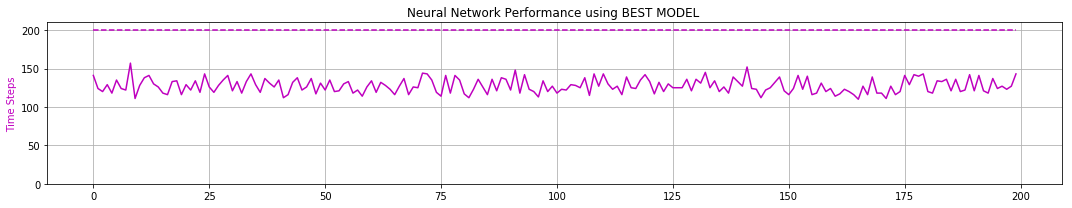

peak memory: 1401.57 MiB, increment: 1034.43 MiB
0 -max- 0.18907772923930108
0 -min- -2.3960619343811125

1 -max- 0.19177454107476466
1 -min- -2.399722013815048

2 -max- 0.2227458011846781
2 -min- -2.3985441617295353

3 -max- 0.2128509556961454
3 -min- -2.3992613148828874

4 -max- 0.20603343775173358
4 -min- -2.3982979839784386

5 -max- 0.1871871084444618
5 -min- -2.3966245073663455

6 -max- 0.1950210554352089
6 -min- -2.3997582980108727

7 -max- 0.2133929253575596
7 -min- -2.3973147238168035

8 -max- 0.24413952510382853
8 -min- -2.3975564434061676

9 -max- 0.2255713192208273
9 -min- -2.3932739591605783

Quantization TIME:  0.18 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   85428
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 111
TOTAL SERIAL TIMESTEPS:   271481
TOTAL PARALLEL TIMESTEPS: 505


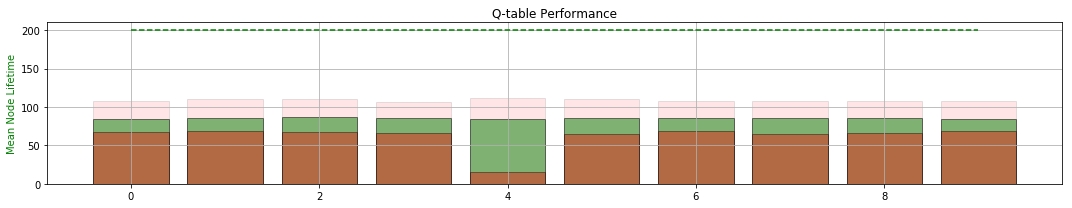

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 223.492	LOSS : 219.227	LOSS : 212.983	LOSS : 205.889	LOSS : 204.564	LOSS : 192.882	LOSS : 192.986	LOSS : 194.772	LOSS : 183.076	LOSS : 189.241	LOSS : 177.505	LOSS : 182.289	LOSS : 180.893	LOSS : 172.002	LOSS : 175.188	LOSS : 175.453	LOSS : 158.048	LOSS : 166.096	LOSS : 177.844	LOSS : 164.973	
Validating... MEAN TIME:  127.26
LOSS : 167.349	LOSS : 175.976	LOSS : 173.668	LOSS : 164.673	LOSS : 172.216	LOSS : 160.927	LOSS : 158.779	LOSS : 176.006	LOSS : 170.156	LOSS : 162.534	LOSS : 179.923	LOSS : 169.073	LOSS : 158.006	LOSS : 160.820	LOSS : 151.568	LOSS : 151.704	LOSS : 161.342	LOSS : 160.892	LOSS : 164.266	LOSS : 161.016	
Validating... MEAN TIME:  112.5
LOSS : 157.061	LOSS : 168.810	LOSS : 162.023	LOSS : 162.995	LOSS : 155.196	LOSS : 163.552	LOSS : 156.685	LOSS : 164.151	LOSS : 154.777	LOSS : 159.782	LOSS : 158.465	LOSS : 152.701	LOSS : 161.245	LOSS : 152.981	LOSS : 151.712	LOSS : 144.463	LOSS : 158

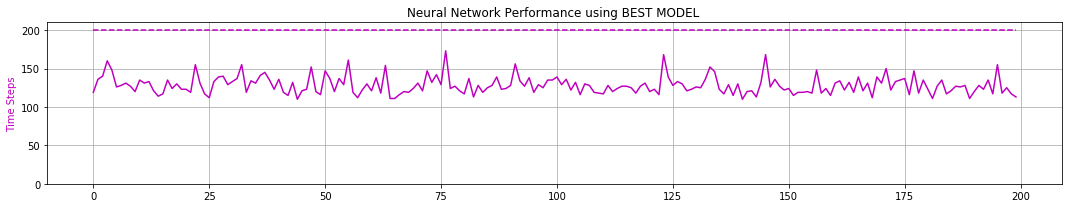

peak memory: 1429.67 MiB, increment: 1020.22 MiB
0 -max- 0.14704450306136818
0 -min- -1.7663463425949795

1 -max- 0.14906575884691067
1 -min- -1.779946430372286

2 -max- 0.15893921200453595
2 -min- -1.6490234843476923

3 -max- 0.1775308160882664
3 -min- -1.744641111720345

4 -max- 0.15827586297949434
4 -min- -1.7829745612928578

5 -max- 0.14695337562807595
5 -min- -1.6870353667846494

6 -max- 0.16174412160753318
6 -min- -1.6825892510419744

7 -max- 0.1519533834311943
7 -min- -1.7230166723721152

8 -max- 0.16630780941416107
8 -min- -1.585287266181309

9 -max- 0.16222932753059258
9 -min- -1.6805828506123084

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   98438
SMALLEST TIMESTEP: 65
LARGEST  TIMESTEP: 156
TOTAL SERIAL TIMESTEPS:   369919
TOTAL PARALLEL TIMESTEPS: 661


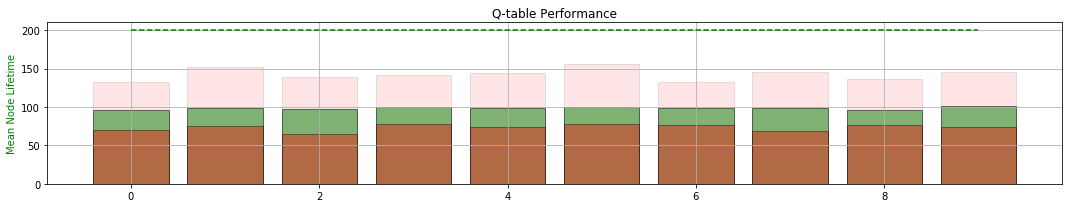

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 135.237	LOSS : 119.586	LOSS : 126.174	LOSS : 125.592	LOSS : 137.319	LOSS : 130.212	LOSS : 136.820	LOSS : 135.295	LOSS : 128.691	LOSS : 126.432	LOSS : 127.358	LOSS : 118.967	LOSS : 119.425	LOSS : 129.990	LOSS : 124.630	LOSS : 134.522	LOSS : 122.340	LOSS : 120.577	LOSS : 113.801	LOSS : 116.705	
Validating... MEAN TIME:  116.32
LOSS : 117.000	LOSS : 120.534	LOSS : 107.338	LOSS : 100.469	LOSS : 108.485	LOSS : 122.041	LOSS : 107.159	LOSS : 103.177	LOSS : 110.540	LOSS : 103.911	LOSS : 108.851	LOSS : 99.060	LOSS : 99.958	LOSS : 104.735	LOSS : 101.532	LOSS : 106.771	LOSS : 95.767	LOSS : 98.805	LOSS : 118.681	LOSS : 111.333	
Validating... MEAN TIME:  58.83
LOSS : 103.890	LOSS : 99.828	LOSS : 126.437	LOSS : 106.024	LOSS : 102.350	LOSS : 101.799	LOSS : 112.570	LOSS : 124.144	LOSS : 100.598	LOSS : 105.984	LOSS : 104.806	LOSS : 111.414	LOSS : 107.642	LOSS : 114.264	LOSS : 110.282	LOSS : 107.695	LOSS : 101.684	

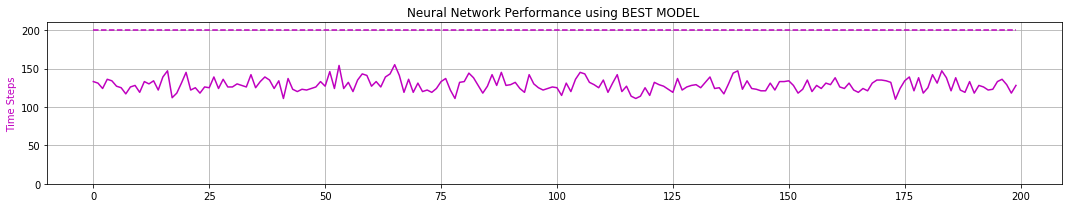

peak memory: 1427.86 MiB, increment: 1015.86 MiB
0 -max- 0.11970698278660158
0 -min- -2.3992847702644347

1 -max- 0.12264823849304726
1 -min- -2.39435714972476

2 -max- 0.1362959029251276
2 -min- -2.3984626861878016

3 -max- 0.11178557426546196
3 -min- -2.399350550889877

4 -max- 0.1039807539227591
4 -min- -2.398065144146403

5 -max- 0.1370120176498769
5 -min- -2.386828464354688

6 -max- 0.11118923474937449
6 -min- -2.3920170890627976

7 -max- 0.12000061499925993
7 -min- -2.3976933078094986

8 -max- 0.11970052911108182
8 -min- -2.394542912017317

9 -max- 0.1362092913877549
9 -min- -2.396348591961498

Quantization TIME:  0.01 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   117629
SMALLEST TIMESTEP: 35
LARGEST  TIMESTEP: 152
TOTAL SERIAL TIMESTEPS:   487548
TOTAL PARALLEL TIMESTEPS: 813


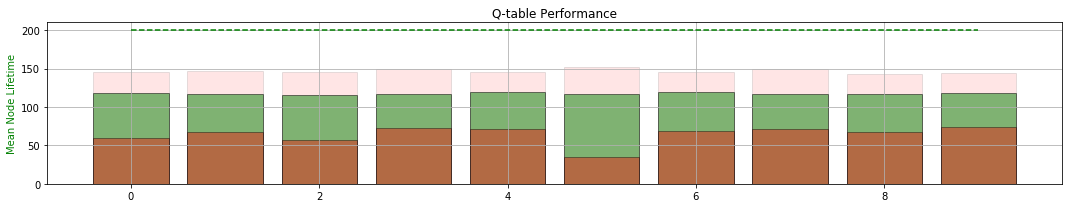

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 172.358	LOSS : 159.343	LOSS : 159.513	LOSS : 140.687	LOSS : 119.952	LOSS : 134.840	LOSS : 132.697	LOSS : 126.242	LOSS : 132.468	LOSS : 120.889	LOSS : 126.207	LOSS : 124.774	LOSS : 122.806	LOSS : 130.422	LOSS : 121.069	LOSS : 119.023	LOSS : 115.560	LOSS : 116.742	LOSS : 119.574	LOSS : 121.850	
Validating... MEAN TIME:  130.785
LOSS : 102.651	LOSS : 125.157	LOSS : 119.044	LOSS : 128.966	LOSS : 115.063	LOSS : 119.266	LOSS : 117.365	LOSS : 116.048	LOSS : 126.134	LOSS : 112.843	LOSS : 127.538	LOSS : 121.557	LOSS : 106.626	LOSS : 115.489	LOSS : 124.416	LOSS : 115.372	LOSS : 112.197	LOSS : 115.793	LOSS : 115.758	LOSS : 113.694	
Validating... MEAN TIME:  162.86
LOSS : 125.060	LOSS : 124.911	LOSS : 118.467	LOSS : 114.840	LOSS : 111.549	LOSS : 116.682	LOSS : 124.370	LOSS : 118.997	LOSS : 122.727	LOSS : 111.577	LOSS : 117.667	LOSS : 120.955	LOSS : 114.406	LOSS : 113.431	LOSS : 110.362	LOSS : 114.418	LOSS : 1

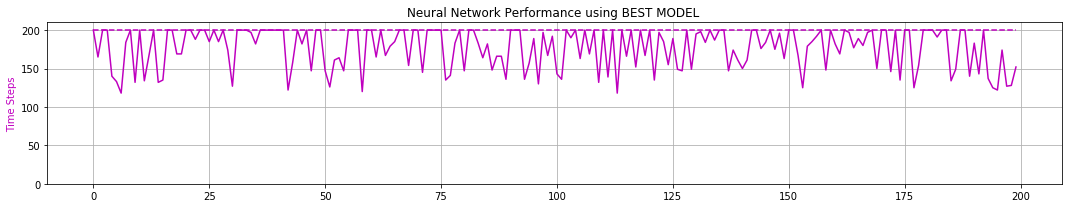

peak memory: 1402.39 MiB, increment: 1016.24 MiB
0 -max- 0.19083697913306366
0 -min- -2.3988087009875243

1 -max- 0.16755589227011963
1 -min- -2.3981436410326853

2 -max- 0.18521655981020246
2 -min- -2.399262137565989

3 -max- 0.1851134948465787
3 -min- -2.3994496974844237

4 -max- 0.17445752304500645
4 -min- -2.3989290111962647

5 -max- 0.17550838284482853
5 -min- -2.3999221621757783

6 -max- 0.18983059358293808
6 -min- -2.3984033125979947

7 -max- 0.18027415624714271
7 -min- -2.3996000927237278

8 -max- 0.20230852350207734
8 -min- -2.399754040975744

9 -max- 0.18296210011251693
9 -min- -2.399865573972659

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   159003
SMALLEST TIMESTEP: 73
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   646551
TOTAL PARALLEL TIMESTEPS: 1013


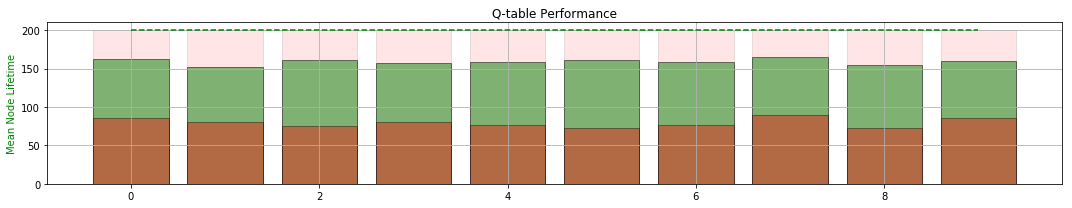

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 64.990	LOSS : 65.011	LOSS : 68.746	LOSS : 76.383	LOSS : 71.702	LOSS : 65.118	LOSS : 86.655	LOSS : 82.164	LOSS : 87.787	LOSS : 71.970	LOSS : 70.801	LOSS : 79.584	LOSS : 75.592	LOSS : 79.235	LOSS : 74.903	LOSS : 80.961	LOSS : 71.764	LOSS : 76.778	LOSS : 73.277	LOSS : 72.311	
Validating... MEAN TIME:  163.72
LOSS : 85.516	LOSS : 74.282	LOSS : 85.372	LOSS : 83.501	LOSS : 88.749	LOSS : 83.096	LOSS : 72.043	LOSS : 75.093	LOSS : 83.449	LOSS : 77.238	LOSS : 81.960	LOSS : 79.573	LOSS : 73.014	LOSS : 75.677	LOSS : 74.195	LOSS : 82.011	LOSS : 83.557	LOSS : 81.818	LOSS : 85.123	LOSS : 77.913	
Validating... MEAN TIME:  153.5
LOSS : 73.935	LOSS : 78.888	LOSS : 78.382	LOSS : 78.563	LOSS : 65.733	LOSS : 76.624	LOSS : 79.368	LOSS : 80.093	LOSS : 82.591	LOSS : 76.747	LOSS : 74.063	LOSS : 79.365	LOSS : 82.147	LOSS : 76.505	LOSS : 77.761	LOSS : 76.257	LOSS : 71.152	LOSS : 84.654	LOSS : 75.271	LOSS : 79.775	
Validatin

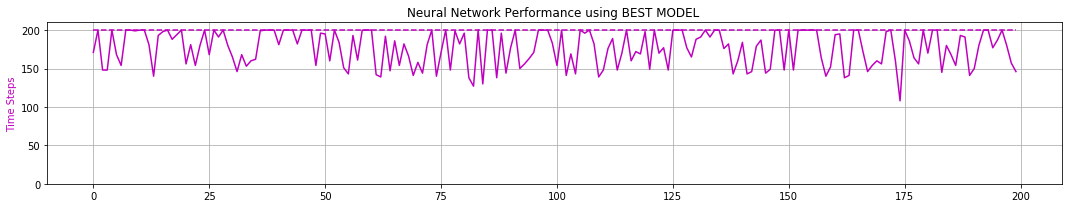

peak memory: 1420.57 MiB, increment: 1016.08 MiB
0 -max- 0.14151898386854636
0 -min- -1.689343081977057

1 -max- 0.3317844140848529
1 -min- -1.7061005029548593

2 -max- 0.1655099525120336
2 -min- -1.6650072877993725

3 -max- 0.2380356942328962
3 -min- -1.691168381037242

4 -max- 0.1360487417138568
4 -min- -1.7580534559868628

5 -max- 0.18007929101724568
5 -min- -1.7472338350149454

6 -max- 0.15441556687723101
6 -min- -1.7103511993693237

7 -max- 0.16333577646923267
7 -min- -1.6673651752286909

8 -max- 0.2536960170606125
8 -min- -1.76108643299815

9 -max- 0.16011656977634964
9 -min- -1.7057273424562849

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   119989
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   766540
TOTAL PARALLEL TIMESTEPS: 1213


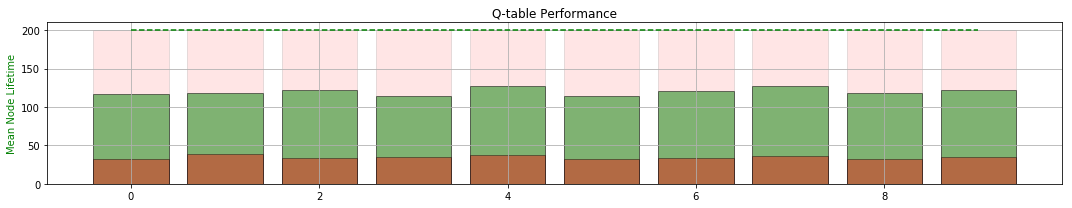

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 98.394	LOSS : 92.521	LOSS : 102.945	LOSS : 100.886	LOSS : 104.944	LOSS : 115.568	LOSS : 115.122	LOSS : 123.668	LOSS : 116.480	LOSS : 116.113	LOSS : 127.695	LOSS : 128.304	LOSS : 119.338	LOSS : 120.895	LOSS : 102.784	LOSS : 112.426	LOSS : 114.147	LOSS : 117.023	LOSS : 105.505	LOSS : 118.444	
Validating... MEAN TIME:  158.845
LOSS : 108.613	LOSS : 122.354	LOSS : 104.475	LOSS : 106.073	LOSS : 102.875	LOSS : 107.869	LOSS : 108.374	LOSS : 120.877	LOSS : 109.659	LOSS : 117.765	LOSS : 107.339	LOSS : 110.070	LOSS : 120.033	LOSS : 106.527	LOSS : 104.687	LOSS : 108.136	LOSS : 102.419	LOSS : 109.184	LOSS : 101.931	LOSS : 103.381	
Validating... MEAN TIME:  143.9
LOSS : 117.992	LOSS : 101.480	LOSS : 106.639	LOSS : 125.251	LOSS : 117.312	LOSS : 126.440	LOSS : 113.717	LOSS : 101.748	LOSS : 115.930	LOSS : 119.905	LOSS : 98.264	LOSS : 112.731	LOSS : 98.708	LOSS : 101.918	LOSS : 96.891	LOSS : 115.286	LOSS : 106.012

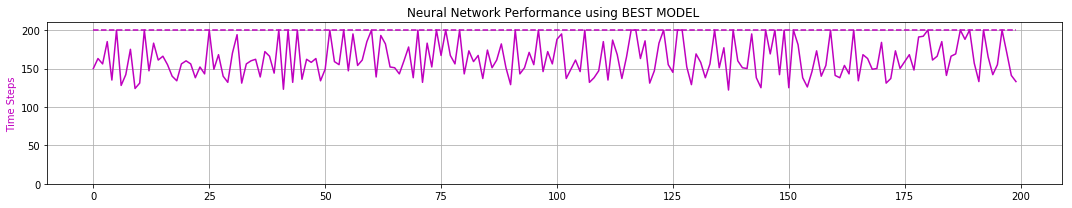

peak memory: 1379.21 MiB, increment: 1035.45 MiB
0 -max- 0.669994293521848
0 -min- -2.372785901772017

1 -max- 0.9928387048098982
1 -min- -1.2869495025657527

2 -max- 0.8405855511674398
2 -min- -2.3846460434190826

3 -max- 1.2571352858177958
3 -min- -2.349008251945626

4 -max- 0.9673433450406642
4 -min- -2.3866221832973453

5 -max- 0.8044317399362679
5 -min- -2.3493668591658374

6 -max- 1.0793977076044636
6 -min- -1.4236626157253698

7 -max- 1.2911918271549176
7 -min- -2.3630292017317736

8 -max- 0.9377258995480638
8 -min- -2.377120969928006

9 -max- 1.233018118085183
9 -min- -2.3829703755271643

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   178568
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   945108
TOTAL PARALLEL TIMESTEPS: 1413


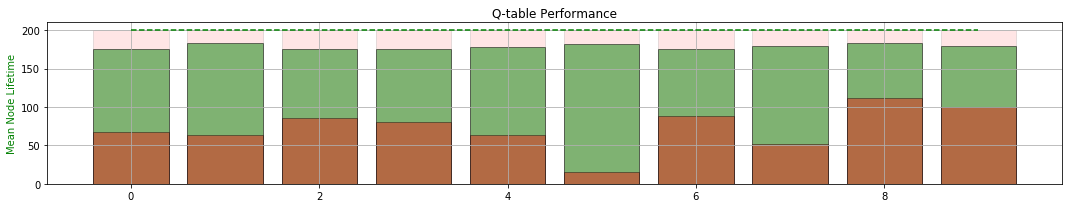

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 82.081	LOSS : 92.026	LOSS : 61.660	LOSS : 73.189	LOSS : 85.318	LOSS : 82.491	LOSS : 73.053	LOSS : 74.094	LOSS : 84.081	LOSS : 73.065	LOSS : 69.000	LOSS : 70.738	LOSS : 73.891	LOSS : 63.634	LOSS : 71.696	LOSS : 77.889	LOSS : 72.700	LOSS : 72.950	LOSS : 70.124	LOSS : 62.897	
Validating... MEAN TIME:  137.885
LOSS : 63.735	LOSS : 57.904	LOSS : 73.719	LOSS : 74.332	LOSS : 72.848	LOSS : 65.418	LOSS : 74.948	LOSS : 64.792	LOSS : 65.121	LOSS : 56.558	LOSS : 60.503	LOSS : 58.354	LOSS : 66.035	LOSS : 67.571	LOSS : 64.436	LOSS : 69.429	LOSS : 66.148	LOSS : 69.316	LOSS : 67.520	LOSS : 64.806	
Validating... MEAN TIME:  132.465
LOSS : 77.134	LOSS : 77.411	LOSS : 68.279	LOSS : 69.515	LOSS : 62.551	LOSS : 69.621	LOSS : 70.414	LOSS : 80.498	LOSS : 64.957	LOSS : 65.611	LOSS : 68.368	LOSS : 73.505	LOSS : 58.472	LOSS : 64.214	LOSS : 73.055	LOSS : 63.267	LOSS : 61.360	LOSS : 71.214	LOSS : 73.928	LOSS : 69.629	
Valida

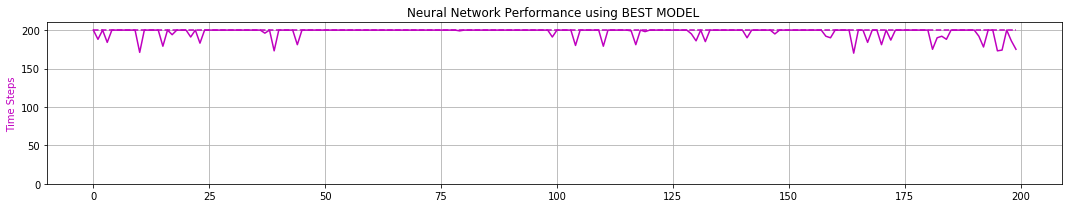

peak memory: 1381.08 MiB, increment: 976.70 MiB
0 -max- 1.5111032323356361
0 -min- -0.9504310905537151

1 -max- 1.5311661228382492
1 -min- -0.9596143686472708

2 -max- 1.5257621107183676
2 -min- -1.214806550542366

3 -max- 1.5891954993169861
3 -min- -0.8829671582154501

4 -max- 1.5091454374830269
4 -min- -1.1834929681263482

5 -max- 1.5581064129497442
5 -min- -0.9656461424425815

6 -max- 1.6090226064281017
6 -min- -0.9433287691974354

7 -max- 1.5672338130899832
7 -min- -0.9409731482012869

8 -max- 1.5757041540921588
8 -min- -0.9304575027270648

9 -max- 1.6756461051626512
9 -min- -0.9650374980845778

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   140784
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 171
TOTAL SERIAL TIMESTEPS:   1085892
TOTAL PARALLEL TIMESTEPS: 1584


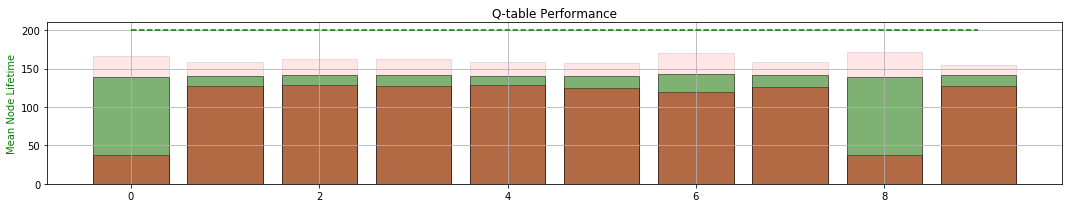

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 85.555	LOSS : 76.624	LOSS : 83.143	LOSS : 82.621	LOSS : 92.002	LOSS : 89.886	LOSS : 90.380	LOSS : 99.911	LOSS : 88.759	LOSS : 68.920	LOSS : 94.516	LOSS : 68.607	LOSS : 81.345	LOSS : 92.989	LOSS : 66.517	LOSS : 76.209	LOSS : 80.402	LOSS : 75.753	LOSS : 79.168	LOSS : 74.563	
Validating... MEAN TIME:  189.545
LOSS : 92.555	LOSS : 81.265	LOSS : 63.216	LOSS : 73.992	LOSS : 78.511	LOSS : 81.511	LOSS : 82.203	LOSS : 70.864	LOSS : 76.577	LOSS : 76.736	LOSS : 80.409	LOSS : 66.917	LOSS : 74.619	LOSS : 67.122	LOSS : 78.508	LOSS : 67.552	LOSS : 65.330	LOSS : 65.446	LOSS : 74.615	LOSS : 79.915	
Validating... MEAN TIME:  163.63
LOSS : 79.847	LOSS : 77.324	LOSS : 74.473	LOSS : 71.915	LOSS : 68.140	LOSS : 79.302	LOSS : 60.718	LOSS : 67.555	LOSS : 68.953	LOSS : 67.237	LOSS : 62.283	LOSS : 81.105	LOSS : 74.051	LOSS : 63.426	LOSS : 71.196	LOSS : 66.501	LOSS : 68.726	LOSS : 71.608	LOSS : 70.112	LOSS : 61.101	
Validat

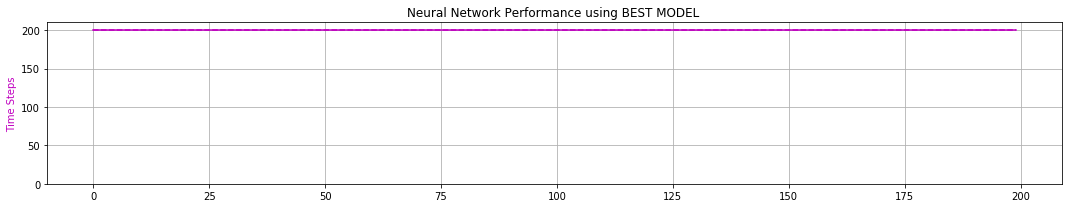

peak memory: 1465.83 MiB, increment: 1003.64 MiB
0 -max- 0.15753325620663533
0 -min- -2.3995345665784784

1 -max- 0.15264198129127288
1 -min- -2.3988347226580613

2 -max- 0.16997744684150887
2 -min- -2.3997535290508294

3 -max- 0.16171052333400796
3 -min- -2.399639443804347

4 -max- 0.17702874422482082
4 -min- -2.3993671991232057

5 -max- 0.13997358274335447
5 -min- -2.3988138113856357

6 -max- 0.16449995656667013
6 -min- -2.3993027698550775

7 -max- 0.1481823945778027
7 -min- -2.3997756765681872

8 -max- 0.15222028618892378
8 -min- -2.39958027909451

9 -max- 0.1652643900161118
9 -min- -2.399496588502581

Quantization TIME:  0.01 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   197172
SMALLEST TIMESTEP: 131
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1283064
TOTAL PARALLEL TIMESTEPS: 1784


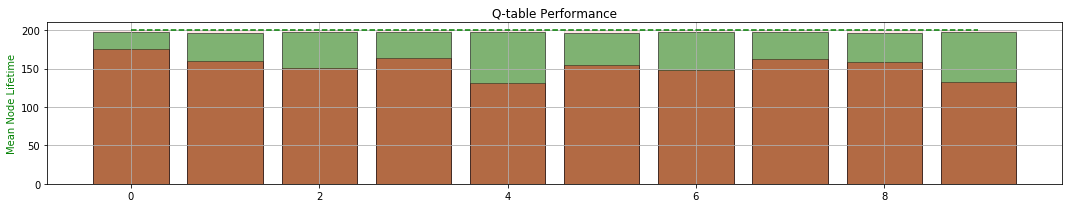

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][0])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1784.0
Total Serial Timesteps   :  1283064.0
Speed-up                 :  719.21


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 131  10    1784    1283064     719.21


In [41]:
node_boundaries

array([[ 0.497,  0.980,  0.066,  1.303, -2.398, -3.358, -0.205, -1.372],
       [ 0.509,  0.975,  0.090,  1.296, -2.397, -3.334, -0.204, -1.099],
       [ 0.443,  0.926,  0.084,  1.420, -2.392, -3.708, -0.208, -1.243],
       [ 0.531,  1.180,  0.117,  1.307, -2.400, -3.145, -0.207, -1.267],
       [ 0.443,  0.818,  0.089,  1.211, -2.395, -3.341, -0.208, -1.106],
       [ 0.476,  0.813,  0.077,  1.315, -2.398, -3.270, -0.206, -1.083],
       [ 0.472,  0.957,  0.095,  1.249, -2.400, -3.146, -0.208, -1.165],
       [ 0.506,  0.992,  0.073,  1.147, -2.396, -3.178, -0.209, -1.134],
       [ 0.430,  0.969,  0.104,  1.306, -2.399, -3.272, -0.209, -1.120],
       [ 0.465,  0.969,  0.097,  1.312, -2.398, -3.495, -0.208, -1.122]])

In [40]:
for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][0])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES])
        print("")
        

0 -max- 0.4967470309395836
0 -min- -2.3975609330682035

1 -max- 0.5085495678527623
1 -min- -2.3974532800567956

2 -max- 0.44271905571152714
2 -min- -2.3918854883027296

3 -max- 0.5314560395207012
3 -min- -2.399675209239063

4 -max- 0.44253279036552207
4 -min- -2.3954096504135616

5 -max- 0.4755969808995018
5 -min- -2.3975395110627167

6 -max- 0.47238390017723336
6 -min- -2.3998931444720806

7 -max- 0.5062293549601576
7 -min- -2.3964789155309267

8 -max- 0.42983228469060114
8 -min- -2.3992435516736266

9 -max- 0.4649326581657983
9 -min- -2.397737211973005

